In [1]:
pip install numpy pandas matplotlib seaborn scikit-learn tensorflow statsmodels flask joblib


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: C:\Users\chinm\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pprint
from matplotlib import style
%matplotlib inline


from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

from statsmodels.tsa.seasonal import seasonal_decompose
import datetime

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import joblib

In [3]:
data = pd.read_csv("CEEW - Smart meter data Bareilly 2020.csv")
print("="*50)
print("First Five Rows ","\n")
print(data.head(5),"\n")

print("="*50)
print("Information About Dataset","\n")
print(data.info(),"\n")

print("="*50)
print("Describe the Dataset ","\n")
print(data.describe(),"\n")

print("="*50)
print("Null Values t ","\n")
print(data.isnull().sum(),"\n")

First Five Rows  

           x_Timestamp  t_kWh  z_Avg Voltage (Volt)  z_Avg Current (Amp)  \
0  2020-01-01 00:00:00  0.002                251.26                 0.15   
1  2020-01-01 00:03:00  0.001                251.23                 0.15   
2  2020-01-01 00:06:00  0.001                251.55                 0.14   
3  2020-01-01 00:09:00  0.001                251.97                 0.14   
4  2020-01-01 00:12:00  0.002                252.03                 0.14   

   y_Freq (Hz) meter  
0        49.97  BR02  
1        49.94  BR02  
2        49.94  BR02  
3        50.09  BR02  
4        50.08  BR02   

Information About Dataset 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6627360 entries, 0 to 6627359
Data columns (total 6 columns):
 #   Column                Dtype  
---  ------                -----  
 0   x_Timestamp           object 
 1   t_kWh                 float64
 2   z_Avg Voltage (Volt)  float64
 3   z_Avg Current (Amp)   float64
 4   y_Freq (Hz)           float64

In [4]:
avg = data['z_Avg Voltage (Volt)'].mean
print(avg)

<bound method Series.mean of 0          251.26
1          251.23
2          251.55
3          251.97
4          252.03
            ...  
6627355    256.10
6627356    256.54
6627357    256.77
6627358    257.29
6627359    257.64
Name: z_Avg Voltage (Volt), Length: 6627360, dtype: float64>


In [5]:
data['x_Timestamp'] = pd.to_datetime(data['x_Timestamp'])

In [6]:
print(data['x_Timestamp'].dtype)

datetime64[ns]


In [7]:
dataset = data
dataset["Month"] = pd.to_datetime(data["x_Timestamp"]).dt.month
dataset["Year"] = pd.to_datetime(data["x_Timestamp"]).dt.year
dataset["Date"] = pd.to_datetime(data["x_Timestamp"]).dt.date
dataset["Minute"] = pd.to_datetime(data["x_Timestamp"]).dt.minute
dataset["Week"] = pd.to_datetime(data["x_Timestamp"]).dt.isocalendar().week
dataset["Day"] = pd.to_datetime(data["x_Timestamp"]).dt.dayofweek 
dataset = data.set_index("x_Timestamp")
dataset.index = pd.to_datetime(dataset.index)
dataset.head(5)

,t_kWh,z_Avg Voltage (Volt),z_Avg Current (Amp),y_Freq (Hz),meter,Month,Year,Date,Minute,Week,Day
x_Timestamp,,,,,,,,,,,
2020-01-01 00:00:00,0.002,251.26,0.15,49.97,BR02,1,2020,2020-01-01,0,1,2
2020-01-01 00:03:00,0.001,251.23,0.15,49.94,BR02,1,2020,2020-01-01,3,1,2
2020-01-01 00:06:00,0.001,251.55,0.14,49.94,BR02,1,2020,2020-01-01,6,1,2
2020-01-01 00:09:00,0.001,251.97,0.14,50.09,BR02,1,2020,2020-01-01,9,1,2
2020-01-01 00:12:00,0.002,252.03,0.14,50.08,BR02,1,2020,2020-01-01,12,1,2


In [8]:
features = data[['z_Avg Voltage (Volt)', 'z_Avg Current (Amp)', 'Minute', 'Week', 'Month', 'Day']]
target = data['t_kWh']

In [9]:
target

0          0.002
1          0.001
2          0.001
3          0.001
4          0.002
           ...  
6627355    0.000
6627356    0.000
6627357    0.000
6627358    0.000
6627359    0.000
Name: t_kWh, Length: 6627360, dtype: float64

In [10]:
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()
features_scaled = scaler_features.fit_transform(features)
target_scaled = scaler_target.fit_transform(target.values.reshape(-1, 1))


In [11]:
joblib.dump(scaler_features, 'scaler_features.pkl')
joblib.dump(scaler_target, 'scaler_target.pkl')

['scaler_target.pkl']

In [12]:
target_scaled

array([[0.00666667],
       [0.00333333],
       [0.00333333],
       ...,
       [0.        ],
       [0.        ],
       [0.        ]])

In [13]:
def create_sequences(features, target, time_steps=10):
    X, y = [], []
    for i in range(len(features) - time_steps):
        X.append(features[i:(i + time_steps)])
        y.append(target[i + time_steps])
    return np.array(X), np.array(y)


In [14]:
time_steps = 10
X, y = create_sequences(features_scaled, target_scaled, time_steps)

In [15]:
    unique_y = np.unique(y)
    print(f"Unique values in y: {unique_y}")

Unique values in y: [0.         0.00333333 0.00666667 0.01       0.01333333 0.01666667
 0.02       0.02333333 0.02666667 0.03       0.03333333 0.03666667
 0.04       0.04333333 0.04666667 0.05       0.05333333 0.05666667
 0.06       0.06333333 0.06666667 0.07       0.07333333 0.07666667
 0.08       0.08333333 0.08666667 0.09       0.09333333 0.09666667
 0.1        0.10333333 0.10666667 0.11       0.11333333 0.11666667
 0.12       0.12333333 0.12666667 0.13       0.13333333 0.13666667
 0.14       0.14333333 0.14666667 0.15       0.15333333 0.15666667
 0.16       0.16333333 0.16666667 0.17       0.17333333 0.17666667
 0.18       0.18333333 0.18666667 0.19       0.19333333 0.19666667
 0.2        0.20333333 0.20666667 0.21       0.21333333 0.21666667
 0.22       0.22333333 0.22666667 0.23       0.23333333 0.23666667
 0.24       0.24333333 0.24666667 0.25       0.25333333 0.25666667
 0.26       0.26333333 0.26666667 0.27       0.27333333 0.27666667
 0.28       0.28333333 0.28666667 0.29    

In [16]:
y

array([[0.00333333],
       [0.00333333],
       [0.00333333],
       ...,
       [0.        ],
       [0.        ],
       [0.        ]])

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
X_train.shape

(5301880, 10, 6)

In [19]:
y_train.shape

(5301880, 1)

In [20]:
y_test

array([[0.34333333],
       [0.26666667],
       [0.02      ],
       ...,
       [0.02      ],
       [0.00666667],
       [0.06      ]])

In [21]:
X_train.shape

(5301880, 10, 6)

In [22]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_steps, X_train.shape[2])))
model.add(LSTM(50))
model.add(Dense(1))


C:\Users\chinm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
##another option ,use it wisely
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 6)))
regressor.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')


##fit
history = regressor.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

In [23]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [24]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
132547/132547 ━━━━━━━━━━━━━━━━━━━━ 527s 4ms/step - loss: 0.0010 - val_loss: 7.8292e-04
Epoch 2/10
132547/132547 ━━━━━━━━━━━━━━━━━━━━ 614s 5ms/step - loss: 7.7626e-04 - val_loss: 7.7317e-04
Epoch 3/10
132547/132547 ━━━━━━━━━━━━━━━━━━━━ 862s 7ms/step - loss: 7.6077e-04 - val_loss: 7.5825e-04
Epoch 4/10
132547/132547 ━━━━━━━━━━━━━━━━━━━━ 737s 6ms/step - loss: 7.4644e-04 - val_loss: 7.4948e-04
Epoch 5/10
132547/132547 ━━━━━━━━━━━━━━━━━━━━ 493s 4ms/step - loss: 7.4002e-04 - val_loss: 7.3511e-04
Epoch 6/10
132547/132547 ━━━━━━━━━━━━━━━━━━━━ 576s 4ms/step - loss: 7.3381e-04 - val_loss: 7.3113e-04
Epoch 7/10
132547/132547 ━━━━━━━━━━━━━━━━━━━━ 954s 7ms/step - loss: 7.2913e-04 - val_loss: 7.2910e-04
Epoch 8/10
132547/132547 ━━━━━━━━━━━━━━━━━━━━ 924s 7ms/step - loss: 7.2014e-04 - val_loss: 7.3417e-04
Epoch 9/10
132547/132547 ━━━━━━━━━━━━━━━━━━━━ 505s 4ms/step - loss: 7.2169e-04 - val_loss: 7.3772e-04
Epoch 10/10
132547/132547 ━━━━━━━━━━━━━━━━━━━━ 474s 4ms/step - loss: 7.1986e-04 - val_

In [25]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

165684/165684 ━━━━━━━━━━━━━━━━━━━━ 255s 2ms/step
41421/41421 ━━━━━━━━━━━━━━━━━━━━ 84s 2ms/step


In [26]:
y_train_pred_rescaled = scaler_target.inverse_transform(y_train_pred)
y_train_rescaled = scaler_target.inverse_transform(y_train)
y_test_pred_rescaled = scaler_target.inverse_transform(y_test_pred) 
y_test_rescaled = scaler_target.inverse_transform(y_test)

In [27]:
train_results = pd.DataFrame(data={'Train Predictions': y_train_pred_rescaled.flatten(), 'Actuals': y_train_rescaled.flatten()})


In [28]:
test_results = pd.DataFrame(data={'Test Predictions': y_test_pred_rescaled.flatten(), 'Actuals': y_test_rescaled.flatten()})

In [29]:
print(train_results.head())
print(test_results.head())

   Train Predictions  Actuals
0           0.002915    0.004
1           0.007755    0.006
2           0.002019    0.002
3           0.000145    0.000
4           0.007999    0.013
   Test Predictions  Actuals
0          0.100705    0.103
1          0.075561    0.080
2          0.005960    0.006
3          0.031039    0.010
4          0.004392    0.004


In [29]:
import joblib
joblib.dump(model, 'lstm_model.pkl')

['lstm_model.pkl']

In [30]:
train_mse = mean_squared_error(y_train_rescaled, y_train_pred_rescaled)
test_mse = mean_squared_error(y_test_rescaled, y_test_pred_rescaled)

In [31]:
print(f'Train Mean Squared Error: {train_mse}')
print(f'Test Mean Squared Error: {test_mse}')

Train Mean Squared Error: 6.367236927245212e-05
Test Mean Squared Error: 6.490701196738313e-05


In [32]:
train_mae = mean_absolute_error(y_train_rescaled, y_train_pred_rescaled)
test_mae = mean_absolute_error(y_test_rescaled, y_test_pred_rescaled)

In [33]:
train_rmse = np.sqrt(mean_squared_error(y_train_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_test_pred_rescaled))

In [34]:
print(f'Train Root Mean Squared Error: {train_rmse}')
print(f'Test Root Mean Squared Error: {test_rmse}')


Train Root Mean Squared Error: 0.00797949680571727
Test Root Mean Squared Error: 0.008056488811348473


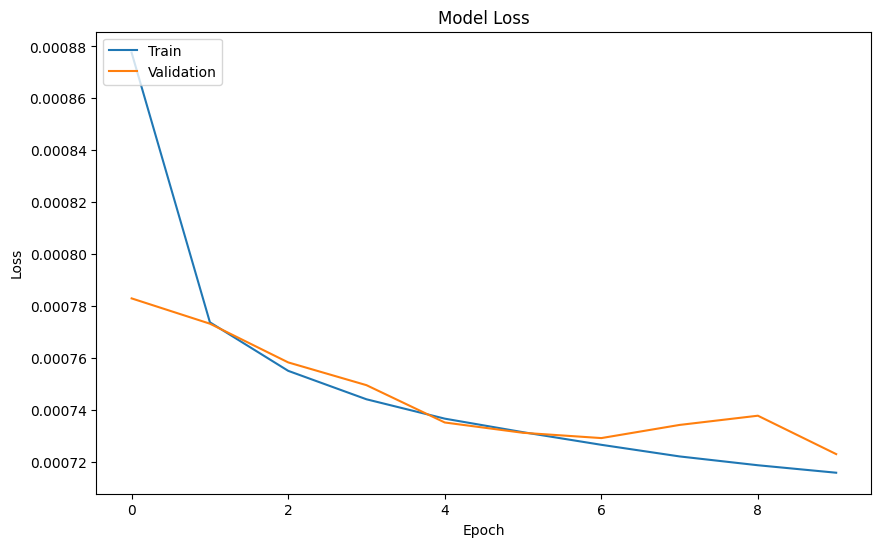

In [35]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [36]:
test_results_with_timestamps = pd.DataFrame(data={
    'Timestamp': data['x_Timestamp'].iloc[-len(y_test_rescaled):].reset_index(drop=True),
    'Test Predictions': y_test_pred_rescaled.flatten(),
    'Actuals': y_test_rescaled.flatten()
})


In [37]:
test_results_with_timestamps['Date'] = test_results_with_timestamps['Timestamp'].dt.date

In [38]:
daily_mae = test_results_with_timestamps.groupby('Date').apply(lambda x: mean_absolute_error(x['Actuals'], x['Test Predictions']))

C:\Users\chinm\AppData\Local\Temp\ipykernel_18364\2958659742.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_mae = test_results_with_timestamps.groupby('Date').apply(lambda x: mean_absolute_error(x['Actuals'], x['Test Predictions']))


In [39]:
best_day = daily_mae.idxmin()
worst_day = daily_mae.idxmax()

In [40]:
print(f'Best day: {best_day} with MAE: {daily_mae.min()}')
print(f'Worst day: {worst_day} with MAE: {daily_mae.max()}')

Best day: 2020-09-18 with MAE: 0.003020396041803445
Worst day: 2020-02-27 with MAE: 0.0037949615215192942


In [41]:
print(f'Daily MAE:\n{daily_mae}')

Daily MAE:
Date
2020-01-01    0.003587
2020-01-02    0.003258
2020-01-03    0.003628
2020-01-04    0.003699
2020-01-05    0.003542
                ...   
2020-12-27    0.003302
2020-12-28    0.003347
2020-12-29    0.003436
2020-12-30    0.003250
2020-12-31    0.003258
Length: 360, dtype: float64


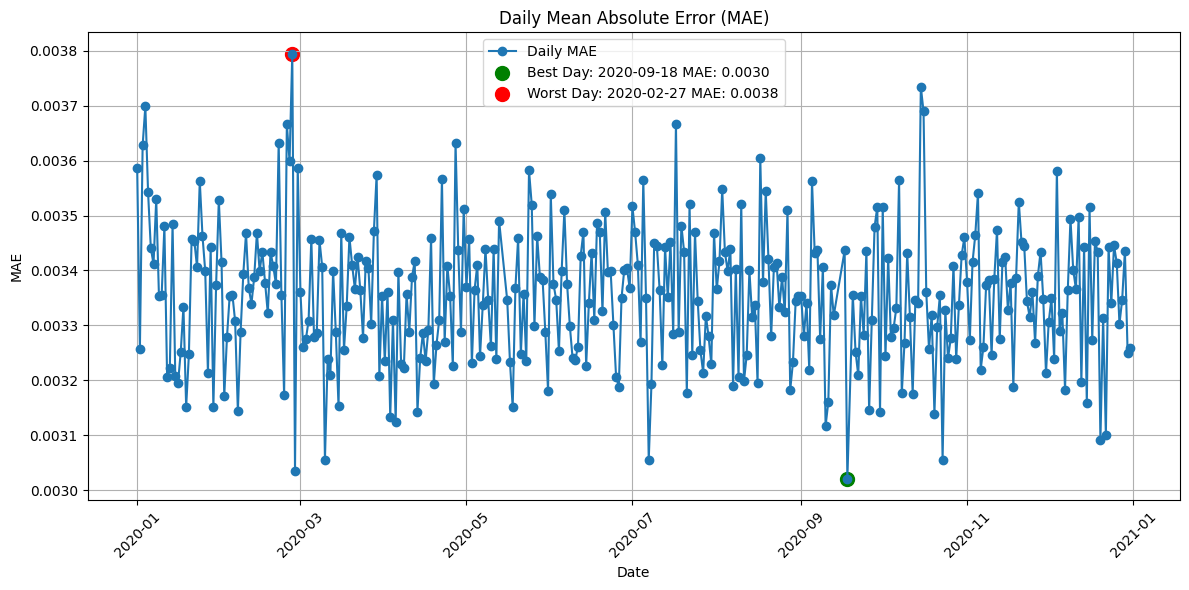

In [42]:
plt.figure(figsize=(12, 6))
plt.plot(daily_mae.index, daily_mae.values, marker='o', linestyle='-', label='Daily MAE')
plt.scatter(best_day, daily_mae.min(), color='green', s=100, label=f'Best Day: {best_day} MAE: {daily_mae.min():.4f}')
plt.scatter(worst_day, daily_mae.max(), color='red', s=100, label=f'Worst Day: {worst_day} MAE: {daily_mae.max():.4f}')
plt.title('Daily Mean Absolute Error (MAE)')
plt.xlabel('Date')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [43]:
test_results_with_timestamps['Date'] = test_results_with_timestamps['Timestamp'].dt.date


In [44]:
daily_mae = test_results_with_timestamps.groupby('Date').apply(
    lambda x: mean_absolute_error(x['Actuals'], x['Test Predictions']))


C:\Users\chinm\AppData\Local\Temp\ipykernel_18364\1237532507.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_mae = test_results_with_timestamps.groupby('Date').apply(


In [45]:
best_day = daily_mae.idxmin()
worst_day = daily_mae.idxmax()

In [46]:
best_day_data = test_results_with_timestamps[test_results_with_timestamps['Date'] == best_day]
worst_day_data = test_results_with_timestamps[test_results_with_timestamps['Date'] == worst_day]


In [47]:
print(best_day)

2020-09-18


In [48]:
print(worst_day)

2020-02-27


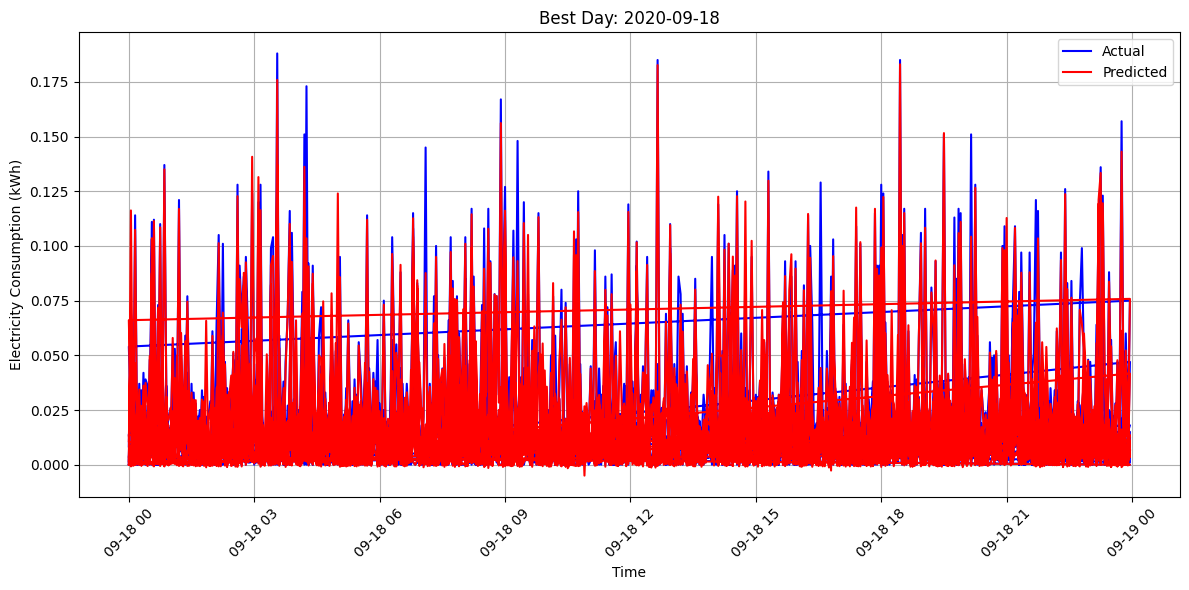

In [49]:
plt.figure(figsize=(12, 6))
plt.plot(best_day_data['Timestamp'], best_day_data['Actuals'], label='Actual', color='blue')
plt.plot(best_day_data['Timestamp'], best_day_data['Test Predictions'], label='Predicted', color='red')

plt.title(f'Best Day: {best_day}')
plt.xlabel('Time')
plt.ylabel('Electricity Consumption (kWh)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

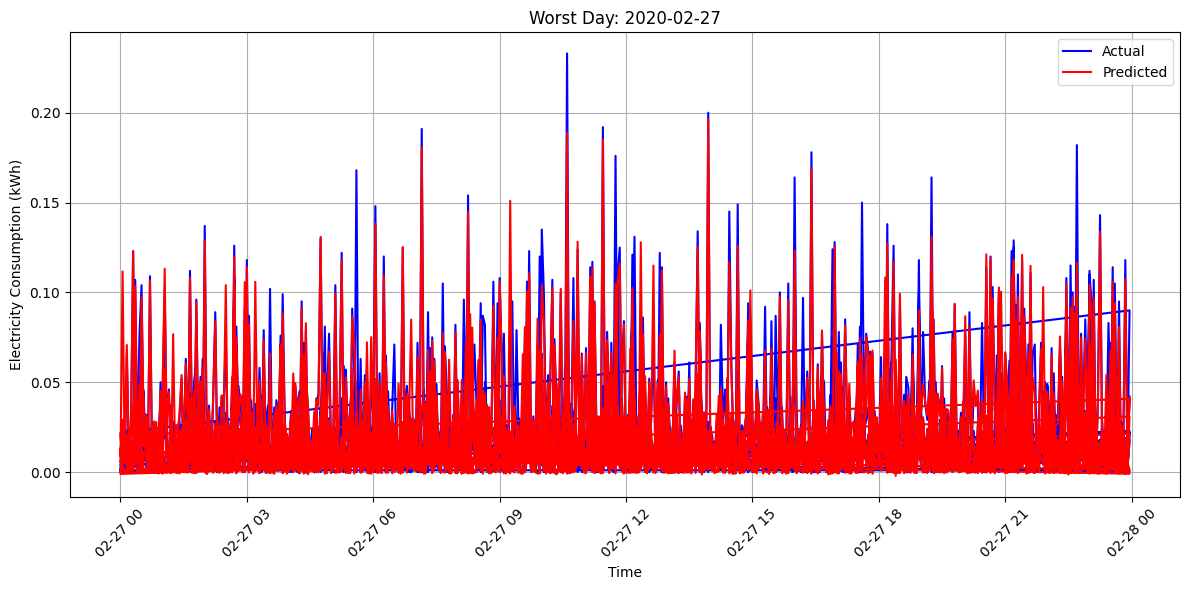

In [50]:
plt.figure(figsize=(12, 6))
plt.plot(worst_day_data['Timestamp'], worst_day_data['Actuals'], label='Actual', color='blue')
plt.plot(worst_day_data['Timestamp'], worst_day_data['Test Predictions'], label='Predicted', color='red')
plt.title(f'Worst Day: {worst_day}')
plt.xlabel('Time')
plt.ylabel('Electricity Consumption (kWh)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()